## 모델 동작에 필요한 사전 준비

In [ ]:
! pip install tensorflow_datasets

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras import Model, layers

2023-06-20 21:56:39.854978: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2023-06-20 21:56:42.396332: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-20 21:56:42.398906: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-20 21:56:42.454452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2023-06-20 21:56:42.454492: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-20 21:56:42.456563: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-20 21:56:42.456648: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10

## 데이터 불러오기 및 전처리

In [5]:
# 이번 GAN 실습에 활용될 MNIST 데이터를 다운로드한 후,
# 불러온 데이터를 Training용과 Testing용으로 나누는 과정
# 모든 이미지 데이터의 크기는 28 x 28 x 1 (흑백)

dataset = tfds.load('mnist', split = 'train')
batch_size = 1024
train_data = dataset.map(lambda data: tf.cast(data['image'], tf.float32) / 255.).batch(batch_size)

2023-06-20 21:56:45.718416: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Couldn't resolve host 'metadata'".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

2023-06-20 21:59:46.925089: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 21:59:46.925856: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-20 21:59:46.926882: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2023-06-20 21:59:46.926973: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-20 21:59:46.927042: I tensorflow/stream_executor/platf

Shuffling /home/piai/tensorflow_datasets/mnist/3.0.1.incompleteWK8R6A/mnist-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/piai/tensorflow_datasets/mnist/3.0.1.incompleteWK8R6A/mnist-test.tfrecord*...:   0%|          …

Dataset mnist downloaded and prepared to /home/piai/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## GAN 구현

### GAN의 생성자 (Generator) 구현

In [6]:
# GAN의 생성자 (Generator)

class Generator(Model):
    def __init__(self, latent_dim):
        super().__init__()

        # 2D convolutional layer의 역연산에 해당하는 transposed 2D convolutional layer의 경우,
        # same padding을 적용하고 strides 값을 2로 할 경우 이미지의 크기가 두 배로 확장되는 효과!
        self.latent_dim = latent_dim
        self.generator = tf.keras.Sequential([
            layers.Dense(7 * 7 * 32, activation = 'relu'),                                          # (batch_size, 7 * 7 * 32) , input_shape = (latent_dim,)
            layers.Reshape((7, 7, 32)),                                                             # (batch_size, 7, 7, 32)
            layers.Conv2DTranspose(64, 3, strides = 2, padding = 'same', activation = 'relu'),      # (batch_size, 14, 14, 64)
            layers.Conv2DTranspose(32, 3, strides = 2, padding = 'same', activation = 'relu'),      # (batch_size, 28, 28, 32)
            layers.Conv2DTranspose(1, 3, strides = 1, padding = 'same', activation = 'sigmoid')     # (batch_size, 28, 28, 1)
        ])

    def call(self, z):
        return self.generator(z)

### GAN의 판별자 (Discriminator) 구현

In [7]:
# GAN의 판별자 (Discriminator)

class Discriminator(Model):
    def __init__(self, latent_dim):
        super().__init__()

        # 2D convolutional layer에서 same padding을 적용하고 strides 값을 2로 할 경우 이미지의 크기가 절반으로 줄어드는 효과!
        self.latent_dim = latent_dim
        self.discriminator = tf.keras.Sequential([
            layers.Conv2D(32, 3, strides = 2, activation = 'relu', padding = 'same', input_shape = (28, 28, 1)),    # (batch_size, 14, 14, 32)
            layers.Conv2D(64, 3, strides = 2, activation = 'relu', padding = 'same'),                               # (batch_size, 7, 7, 64)
            layers.Flatten(),                                                                                       # (batch_size, 7 * 7 * 64)
            layers.Dense(1)                                                                                         # (batch_size, )
        ])

    def call(self, x):
        return self.discriminator(x)

### GAN 구조 정의

In [8]:
# Hyperparameters

n_epochs = 200
latent_dim = 10
log_interval = 20

In [9]:
# GAN의 생성자와 판별자
generator = Generator(latent_dim)
discriminator = Discriminator(latent_dim)

# Optimizer 정의
optimizer_g = tf.keras.optimizers.Adam(1e-3)
optimizer_d = tf.keras.optimizers.Adam(1e-3)

## Training

### Loss Function 정의

In [10]:
# Loss function은 binary cross entropy (BCE)로 정의
# from_logits = True로 할 경우 여러 catagory로 분류하는 task에서도 loss function으로 binary cross entropy 함수를 사용할 수 있음!
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [11]:
def train_step(inputs):
    noises = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as tape_g, tf.GradientTape() as tape_d:
        # noises: random noise 분포에서 sample된 벡터
        # x: noises로부터 생성된 MNIST 이미지
        # real_output: 실제 MNIST 이미지 판별 결과
        # fake_output: GAN의 생성자가 생성한 MNIST 이미지의 판별 결과

        x = generator(noises) # = fack_images

        real_output = discriminator(inputs) #discriminator(true_images)
        fake_output = discriminator(x) # discriminator(fake_images)

        # Generator loss와 discriminator loss 계산
        loss_g = loss(tf.ones_like(fake_output), fake_output)
        loss_d = loss(tf.ones_like(real_output), real_output) + loss(tf.zeros_like(fake_output), fake_output)

    # GAN을 구성하는 생성자와 판별자의 gradient 값들을 계산하는 과정
    grads_g = tape_g.gradient(loss_g, generator.trainable_variables)
    grads_d = tape_d.gradient(loss_d, discriminator.trainable_variables)

    # 계산된 gradient 값들을 기반으로 GAN의 생성자와 판별자를 optimize하는 과정
    optimizer_g.apply_gradients(zip(grads_g, generator.trainable_variables))
    optimizer_d.apply_gradients(zip(grads_d, discriminator.trainable_variables))

    return loss_g, loss_d

In [12]:
# 실제 Training 과정

for epoch in range(1, n_epochs + 1):
    total_loss_g, total_loss_d = 0, 0

    for x in train_data:
        loss_g, loss_d = train_step(x)
        total_loss_g += loss_g
        total_loss_d += loss_d

    if epoch % log_interval == 0:
        print(f'Epoch {epoch:3d} - Generator loss: {total_loss_g:.2f}, Discriminator loss: {total_loss_d:.2f}')

2023-06-20 22:00:00.804530: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-20 22:00:00.824289: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2023-06-20 22:00:01.048303: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-20 22:00:01.268950: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-06-20 22:00:02.316907: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-06-20 22:00:02.381692: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Epoch  20 - Generator loss: 135.43, Discriminator loss: 33.43
Epoch  40 - Generator loss: 101.55, Discriminator loss: 46.45
Epoch  60 - Generator loss: 84.46, Discriminator loss: 59.20
Epoch  80 - Generator loss: 72.01, Discriminator loss: 65.52
Epoch 100 - Generator loss: 86.74, Discriminator loss: 53.47
Epoch 120 - Generator loss: 92.01, Discriminator loss: 51.67
Epoch 140 - Generator loss: 88.29, Discriminator loss: 54.91
Epoch 160 - Generator loss: 87.18, Discriminator loss: 56.64
Epoch 180 - Generator loss: 79.93, Discriminator loss: 59.44
Epoch 200 - Generator loss: 72.71, Discriminator loss: 64.11


## Testing

### 생성자 동작 확인

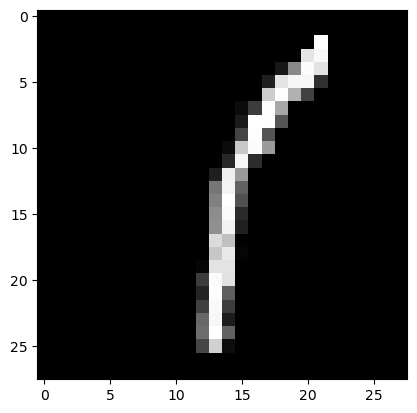

In [13]:
# 학습된 GAN 모델의 생성자로 MNIST 이미지 Sampling 및 시각화

noise = tf.random.normal([1, latent_dim])
x = generator(noise)
plt.imshow(x[0, :, :, 0], cmap = 'gray')

### 학습된 GAN 모델로 MNIST 이미지 생성

In [14]:
# 여러 개의 MNIST 이미지들을 Sampling하는 함수 정의
# n * n 정사각형 배치의 MNIST 이미지 생성 및 출력

def plot_latent_images(n, digit_size = 28):
    image_width = digit_size * n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i in range(n):
        for j in range(n):
            noise = tf.random.normal([1, latent_dim])
            x = generator(noise)
            image[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size] = x[0, :, :, 0]

    plt.figure(figsize = (10, 10))
    plt.imshow(image, cmap = 'Greys_r')
    plt.axis('Off')
    plt.show()

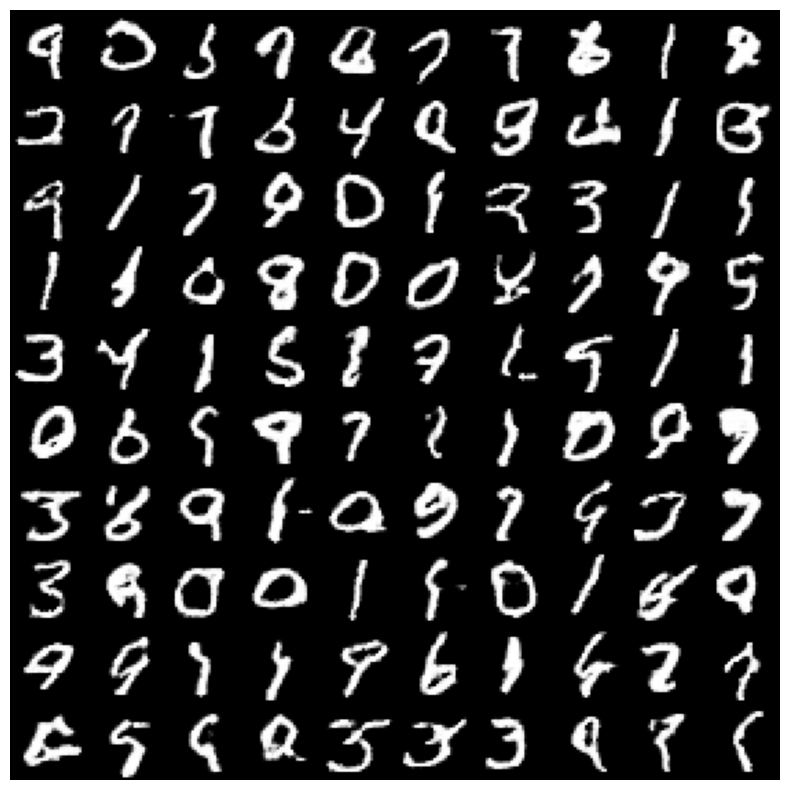

In [15]:
# MNIST 이미지 생성
# 여기서는 10 * 10 = 100개의 MNIST 이미지 생성

plot_latent_images(10)